## Processing CORD-19 Articles with FastText
This notebook attempts to vectorize documents in the CORD-19 corpus by leveraging semantically relevant word embeddings produced by [FastText](https://fasttext.cc/).

In [89]:
import json
import os
import numpy as np
import fasttext
import string
import matplotlib.pyplot as plt
# For three dimensional plotting
from mpl_toolkits.mplot3d import Axes3D
import unidecode
import re
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans

Load CORD-19 data. Change path accordingly.

In [2]:
# Path to general CORD-19 Data on my local machine
path = "/Users/ryersonburdick/Desktop/CORD-19-research-challenge"
# Path to biorxiv/medrxiv articles
biomed = path + "/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
# Path to comm use PMC articles
pmc = path + "/comm_use_subset/comm_use_subset/pmc_json"

Doc class stores required info from CORD-19 json files.

In [3]:
class Doc:
    """
    Stores data from CORD-19 json files.

    Attributes:
        id : string
        title : string
        authors : list of string
        text : string
        vec : numpy array
    """

    def __init__(self, json_file):
        """
        Create Doc object from json file from CORD-19 dataset.

        json_file : string
            path to json file from CORD-19 datset
        """

        # Open json file
        doc = json.loads(open(json_file, "r").read())

        # Extract paper id
        self.id = doc["paper_id"]

        # Extract paper title, make lowercase for normalization purposes
        self.title = doc["metadata"]["title"].lower()

        # Extract author data (list of dicts contain first, last, etc.)
        authors = doc["metadata"]["authors"]
        self.authors = [
            author["first"] + " " + " ".join(author["middle"])
            + ("" if author["middle"] == [] else " ") + author["last"]
            for author in authors]

        # Extract all text from abstract
        abstr = ""
        if "abstract" in doc:
            self.abstr = " ".join([par["text"] for par in doc["abstract"]])
        # Extract all paragraphs from body
        body = " ".join([par["text"] for par in doc["body_text"]])
        self.text = abstr + " " + body

Load data from directory containing CORD-19 articles into list of Doc objects.

In [4]:
def load_from_dirs(dirs):
    """
    Returns number of articles and list of article info for each article
    in a CORD-19 subdir containing json files.

    dir : list of string
        List of paths to directories containing CORD-19 json files.
    """

    doclist = []
    for dir in dirs:
        print("Reading files from directory: " + dir)
        for file in os.listdir(dir):
            if file.endswith(".json"):
                # Read file text
                fullpath = dir + "/" + file
                # Create Doc object and add to doclist
                doc = Doc(fullpath)
                doclist.append(doc)

    return doclist

In [42]:
def clean_text(s):
    """
    Returns a cleaned string with punctuation, accents, and capitalization removed. Citations in the form
    (1) are removed.
    
    s : string
    """
    
    # Remover accents (convert to ASCII string)
    s = unidecode.unidecode(s)
    # Remove citations
    s = re.sub("\([0-9]+(?:,[ ]?[0-9]+)*\)", "", s)
    
    # Remove punctuation
    trans = str.maketrans(' ', ' ', string.punctuation)
    s = s.translate(trans)
    # Remove capitalization
    return s.lower()

In [43]:
# Use biomed dir for testing
doclist = load_from_dirs([biomed])
corpus = [clean_text(doc.text) for doc in doclist]
fulltext = ""
for text in corpus:
    fulltext += (text + " ")

Reading files from directory: /Users/ryersonburdick/Desktop/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json


In [49]:
# Write full corpus to file for training fasttext model
output = "cord19_fulltext.txt"
with open(output, 'w') as file:
    file.write(fulltext)

In [50]:
# Train fasttext model to produce word embeddings for n-grams in provided corpus
# Word vectors produced are of size 100
model = fasttext.train_unsupervised(output)

In [114]:
def vectorize(s, model):
    """
    Vectorizes a string using the provided fasttext model. Splits the string by whitespace and
    returns the average word vector obtained form each resulting word. Unrecognized words assigned zero vector.
    
    s : string
    model : fasttext model
    """
    
    wordlist = s.split()
    vec = np.zeros(100)
    for word in wordlist:
        vec += model.get_word_vector(word)
    vec /= len(wordlist)
    return vec

In [115]:
vectors = [vectorize(text, model) for text in corpus]
mat = np.column_stack(vectors).T

In [118]:
def ipca(arr, n_dims, batch_size):
    """
    Reduce input array dimension using IPCA.
    
    arr : np.ndarray
    n_dims : int, number of output dimensions
    batch_size : int, batch size for IPCA
    """
    
    transform = IncrementalPCA(n_components=n_dims, batch_size=batch_size)
    transform.fit(arr)
    res = transform.transform(arr)
    return res

In [119]:
n_clusters = 3
mat = ipca(mat, n_clusters, 100)

In [120]:
# Performing K-Means
kmeans = KMeans(n_clusters=n_clusters)
kmeans = kmeans.fit(mat)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


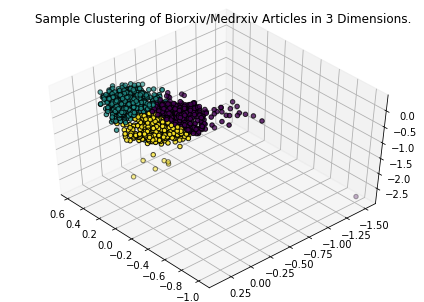

In [121]:
# 3 dimensional plotting
fig = plt.figure()
fig.suptitle("Sample Clustering of Biorxiv/Medrxiv Articles in 3 Dimensions.")
y_vals = kmeans.predict(mat)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=138)
ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=y_vals, edgecolor='k')
fig.show()